In this post, I would like to share the steps to build a fun project implementing a console-based progress-spinner that runs in a separate thread while executing arbitrary code in the main thread. The code I'm sharing is compatible with WindowsPowerShell 5.1 and works best when executed within Windows Terminal rather than the PowerShell console window. To keep the cursor in the same position, while writing the progress, we will make use of [ANSI-Escape sequences](https://docs.microsoft.com/en-us/windows/console/console-virtual-terminal-sequences). 

Let's start with a very simple example just to show how it works.

In [ ]:
function simpleSpinner {
    ~~e = "~~([char]27)"
    1..10 | foreach -Begin { Write-Host "~~e[s" -NoNewline} -Process { 
        Write-Host "~~e[u~~_" -NoNewLine; Start-Sleep -MilliSeconds 100 
    }
}

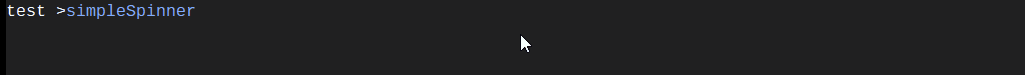

The variable`~~e` in the example above holds the escape sequence that precedes any ANSI-Escape sequence (PowerShell 7 introduced the ``e` `` character sequence for that purpose see [here](https://docs.microsoft.com/en-us/powershell/module/microsoft.powershell.core/about/about_special_characters?view=powershell-7.1). The two escape sequences used do the following:

| Sequence | Description                        |
|----------|------------------------------------|
| \~~e[s     | Save the current cursor position   |
| \~~e[u     | Restore the saved cursor position. |

With the basic logic out of the way, we need to figure out the spinner design. Luckily, the [cli-spinners project on GitHub](https://github.com/sindresorhus/cli-spinners) includes a JSON file with a collection of terminal spinner icons that can be used to show an animation during a longer running process. 
Let's write a PowerShell function that makes use of those for a light-weight Write-Progress version. 

First, we need to download the JSON file and convert it to a PowerShell object and check what we got (the output is only showing the first few entries to save space)

In [3]:
~~url = 'https://raw.githubusercontent.com/sindresorhus/cli-spinners/main/spinners.json'
~~json = (Invoke-WebRequest -Uri ~~url).Content 
~~spinners = ~~json | ConvertFrom-Json 


aesthetic : @{interval=80; frames=System.Object[]}
arc       : @{interval=100; frames=System.Object[]}
arrow     : @{interval=100; frames=System.Object[]}
arrow2    : @{interval=80; frames=System.Object[]}
arrow3    : @{interval=120; frames=System.Object[]}




Ok, what we got is one PSCustomObject with one property per spinner icon set.

In [8]:
~~spinners.bouncingBall.frames

( â—    )
(  â—   )
(   â—  )
(    â— )
(     â—)
(    â— )
(   â—  )
(  â—   )
( â—    )
(â—     )


In order to pick from the spinner icon sets, I'd like to have a parameter that'll provide me with all the possible icon set names. We can use `Get-Member` and `ValidateSet` to do this.

In [ ]:
(~~spinners | Get-Member -MemberType NoteProperty).Name.foreach{"'~~_'"} -join ',' | clip
#pasted the copied names below
function Write-TerminalProgress {
    [CmdletBinding()]
    Param(
        [ValidateSet('aesthetic','arc','arrow','arrow2','arrow3','balloon','balloon2','betaWave','bluePulse','bounce','bouncingBall','bouncingBar','boxBounce','boxBounce2','christmas','circle','circleHalves','circleQuarters','clock','dots','dots10','dots11','dots12','dots2','dots3','dots4','dots5','dots6','dots7','dots8','dots8Bit','dots9','dqpb','earth','fingerDance','fistBump','flip','grenade','growHorizontal','growVertical','hamburger','hearts','layer','line','line2','material','mindblown','monkey','moon','noise','orangeBluePulse','orangePulse','pipe','point','pong','runner','shark','simpleDots','simpleDotsScrolling','smiley','soccerHeader','speaker','squareCorners','squish','star','star2','timeTravel','toggle','toggle10','toggle11','toggle12','toggle13','toggle2','toggle3','toggle4','toggle5','toggle6','toggle7','toggle8','toggle9','triangle','weather')]
        ~~IconSet
    )
}

Now let's add the logic to display the spinner icons with the help of the ANSI-Escape sequences. I have saved the JSON file locally in order to avoid downloading it every time I run the function.

In [ ]:
(Invoke-WebRequest -Uri ~~url).Content  | 
    Set-Content -Path ~~env:USERPROFILE\Desktop\spinners.json -Encoding UTF8

In [9]:
function Write-TerminalProgress {
    [CmdletBinding()]
    Param(
        [Parameter(Mandatory)]
        [ValidateSet('aesthetic','arc','arrow','arrow2','arrow3','balloon','balloon2','betaWave','bluePulse','bounce','bouncingBall','bouncingBar','boxBounce','boxBounce2','christmas','circle','circleHalves','circleQuarters','clock','dots','dots10','dots11','dots12','dots2','dots3','dots4','dots5','dots6','dots7','dots8','dots8Bit','dots9','dqpb','earth','fingerDance','fistBump','flip','grenade','growHorizontal','growVertical','hamburger','hearts','layer','line','line2','material','mindblown','monkey','moon','noise','orangeBluePulse','orangePulse','pipe','point','pong','runner','shark','simpleDots','simpleDotsScrolling','smiley','soccerHeader','speaker','squareCorners','squish','star','star2','timeTravel','toggle','toggle10','toggle11','toggle12','toggle13','toggle2','toggle3','toggle4','toggle5','toggle6','toggle7','toggle8','toggle9','triangle','weather')]
        ~~IconSet
    )
    ~~path = "~~env:USERPROFILE\Desktop\spinners.json"
    ~~spinners = Get-Content ~~path | ConvertFrom-Json 
    ~~frameCount = ~~spinners.~~IconSet.frames.count
    ~~frameLength = ~~spinners.~~IconSet.frames[0].Length
    ~~frameInterval = ~~spinners.~~IconSet.interval
    ~~e = "~~([char]27)"
    1..30 | foreach -Begin {write-host "~~(~~e)[s" -NoNewline} -Process { 
        ~~frame = ~~spinners.~~IconSet.frames[~~_ % ~~frameCount]
        Write-Host "~~e[u~~frame" -NoNewline
        Start-Sleep -Milliseconds ~~frameInterval
    }
    Write-Host "~~e[u~~(~~e)[~~(~~frameLength)PDone." -NoNewline
}

Let's give this version a spin (no pun intended) before we look into the details.

In [ ]:
Write-TerminalProgress -IconSet soccerHeader

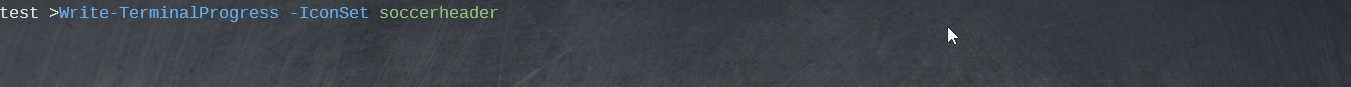

Nice! Let's look at the additions and think about what else we want to add to turn this into a re-usable function.
- Based on the selected IconSet the following information is retrieved:
   - The number of frames within the IconSet (frameCount).
   - The length of the frame(s) (frameLength).
   - The interval at which we need to switch the frames.
- Within the `Process` block of the `Foreach-Object` cmdlet we retrieve the frame based on the modulo operation.
- During each iteration, the frame is written to the console after which the process is paused based on the interval.
- After the loop finished we overwrite the Iconset using the two sequences:
   - `~~e[u` to restore the cursor position.
   - `~~e[~~(~~frameLength)PDone."` to delete the last iconset and write the text `Done.`. 
      - `~~e[<NUMCHARSTODELETE>P`



Those are the additional requirements for the next iteration of `Write-TerminalProgress`:
- Ability to provide InputObject(s) argument to iterate over via Pipeline.
- Ability to provide script block arguments for the logic to be executed (similar to Foreach-Object's Begin|Process|End parameters.
- Ability to Provide custom Activity (name for the overall process) and CurrentStatus (message displayed for each iteration) texts

For the ability to execute a script while showing progress at the same time we will need a separate thread (using `Start-ThreadJob` from the [PSThreadJob module](https://github.com/PaulHigin/PSThreadJob)) that writes the progress to the console while the Process script block is running and potentially also emits some output to the console within the main thread. In order for the progress output not to interfere with the "normal" output, I put the progress output at the top left hand corner of the console window. We also need to add some additional ANSI-escape sequence and `[System.Console]` methods to control the display. You can read about the difference between the console buffer and the viewport/window [here](https://docs.microsoft.com/en-us/windows/console/scrolling-the-screen-buffer).

| Sequence                                                                                                                 | Description                                                                                                                                                                                                                                                                 |
|--------------------------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| \\~~e[s\\~~(\\~~e)[4;r\\~~(\\~~e)[u                                                                                                     | Define scrolling region. This sequence can take two parameters separated by semicolon the top row (defaults to 1) and left column of the scrolling region (defaults to the window height. In addition the  cursor position is saved and restored to its original position.  |
| \\~~e[2J;[console]::SetCursorPosition(0,[console]::WindowTop+6)                                                         | This is similar to clear screen, but does not delete the screen buffer. It moves the used buffer up to clear the wimdpw. The SetCursorPosition moves the cursor to the top of the viewport - 6 rows.                                                                        |
| [console]::MoveBufferArea(0,[ console]::WindowTop,[console]::WindowWidth, [console]::WindowTop,0,[console]::WindowTop+5) | Clears the top 5 rows of the viewport by moving the buffer down 5 rows  within the current window.                                                                                                                                                                          |
| \\~~e[?25l                                                                                                                  | Hide the cursor to avoid flickering during updates.                                                                                                                                                                                                                         |
| \\~~e[?25h                                                                                                                  | Show the cursor.                                                                                                                                                                                                                                                            |

Since this is not trivial, I put together a proof of concept to test this functionality. I've added comments to try to illustrate how the different pieces fit together.

In [12]:
function testing {
    [CmdletBinding()]
    Param(
        [Parameter(Mandatory,ValueFromPipeline)]
        ~~InputObject,
        [Parameter(Mandatory)]
        [ScriptBlock]~~Process,
        [switch]~~ReturnFullOutput
    )
    BEGIN{
        ~~e = "~~([char]27)"
        #clear screen w/o buffer
        "~~e[2J"
        #move cursor down by 6
        [console]::SetCursorPosition(0,[console]::WindowTop+6)
        #move everything down 5 lines to make space
        [console]::MoveBufferArea(0,[console]::WindowTop,[console]::WindowWidth,[console]::WindowTop,0,[console]::WindowTop+5) 
        #hide the cursor
        Write-Host "~~e[?25l"  -NoNewline  
        #array list to collect output
        ~~output = [System.Collections.ArrayList]::new()
        #create a thread safe object to be able to...
        #...communicate across threads
        ~~currentObject = [System.Collections.Concurrent.ConcurrentDictionary[string,object]]::new()
        #define scrolling region making the top 3 rows a no scrolling area
        #see https://docs.microsoft.com/en-us/windows/console/console-virtual-terminal-sequences
        Write-Host "~~e[s~~(~~e)[4;r~~(~~e)[u" -NoNewline
        #start the thread that show the progress
        ~~job= Start-ThreadJob {
            ~~e = "~~([char]27)"
            #run this in an infinite loop until the actual job is done
            while (~~true){
                #retrieve the currently processed ...
                #...pipeline variable from the main thread
                ~~current = ~~using:currentObject
                #safe the current cursor position
                Write-Host "~~e[s" -NoNewline
                #place the cursor at the top left position with some margin
                [console]::SetCursorPosition([console]::WindowWidth-20,[console]::WindowTop+2)
                [console]::Write("~~(~~e)[~~(20)P~~((~~i++)):~~(~~current.curr)")
                #restore the cursor position
                Write-Host "~~e[u" -NoNewline
                sleep -Milliseconds 100 
            }
        } -StreamingHost ~~host 
    }
    #process the actual Process scriptblock using foreach object
    #to be able to refer to ~~_ inside the script block
    PROCESS{
       ~~Null = ~~currentObject['curr'] = ~~InputObject
       ~~null = ~~output.Add((~~InputObject | foreach -Process ~~Process))
       ~~output[-1]

    }

    END{
        #clean up the job
        ~~job | Stop-job -PassThru | Remove-Job
        #remove the progress message
        [console]::Write("~~e[s")
        [console]::SetCursorPosition([console]::WindowWidth-20,[console]::WindowTop+2)
        [console]::Write("~~e[20P")
        [console]::Write("~~e[u")
        #restore scrolling region
        Write-Host "~~e[s~~(~~e)[r~~(~~e)[u" -NoNewline
        #show the cursor
        Write-Host "~~e[?25h" -NoNewline  
        if (~~ReturnFullOutput){
            ~~output
        }
    }
}

We can execute the test function with some dummy operation simulating processing. Let's simulate two runs with longer output to demonstrate the scrolling behaviour and the preservation of the screen buffer. The output that is scrolled due to the no-scrolling region is partially cut-off. Therefore. I've added a parameter to the funciton to optionally return the full output, too (`ReturnFullOutput`).

In [ ]:
~~margin = [console]::WindowWidth/2-~~text.Length
'#' * ~~margin + 'first iteration' + '#' * ~~margin
1..5 | testing -Process {"Processing item ~~_";~~_..10;sleep -seconds 2}
'#' * ~~margin + 'second iteration' + '#' * ~~margin
1..5 | testing -Process {"Processing item ~~_";~~_..10;sleep -seconds 2}

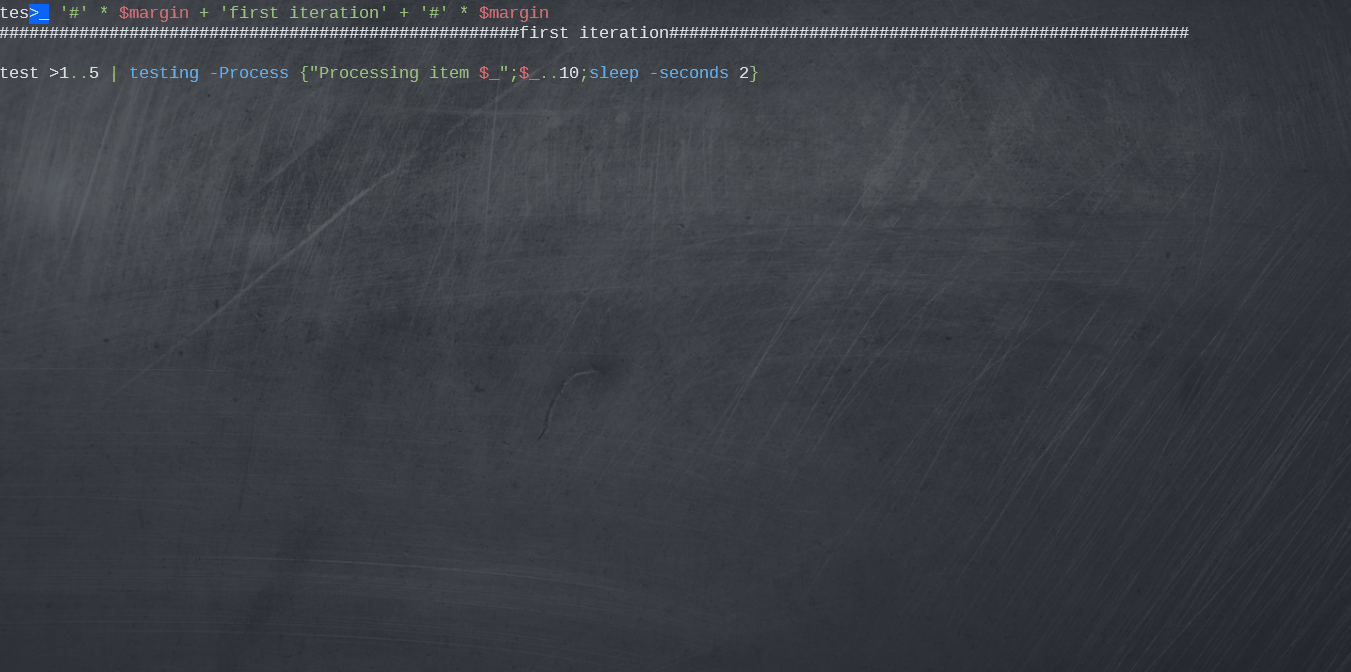

We now only need to add the remainder of the requirements to finish `Write-TerminalProgress`. Other than the additional logic, I have only made use of one additional escape sequence for positioning the cursor instead of using `[Sytsem.Console]::SetCursorPosition`: `~~e[<y>;<x>H`.

In [ ]:
function Write-TerminalProcess {
    [CmdletBinding()]
    Param(
        [Parameter(Mandatory,ValueFromPipeline)]
        ~~InputObject,
        [Parameter(Mandatory)]
        [ValidateSet('aesthetic','arc','arrow','arrow2','arrow3','balloon','balloon2','betaWave','bluePulse','bounce','bouncingBall','bouncingBar','boxBounce','boxBounce2','christmas','circle','circleHalves','circleQuarters','clock','dots','dots10','dots11','dots12','dots2','dots3','dots4','dots5','dots6','dots7','dots8','dots8Bit','dots9','dqpb','earth','fingerDance','fistBump','flip','grenade','growHorizontal','growVertical','hamburger','hearts','layer','line','line2','material','mindblown','monkey','moon','noise','orangeBluePulse','orangePulse','pipe','point','pong','runner','shark','simpleDots','simpleDotsScrolling','smiley','soccerHeader','speaker','squareCorners','squish','star','star2','timeTravel','toggle','toggle10','toggle11','toggle12','toggle13','toggle2','toggle3','toggle4','toggle5','toggle6','toggle7','toggle8','toggle9','triangle','weather')]
        ~~IconSet,
        [ScriptBlock]~~Begin,
        [Parameter(Mandatory)]
        [ScriptBlock]~~Process,
        [ScriptBlock]~~End,
        [String]~~Activity,
        [String]~~CurrentStatus,
        [switch]~~ReturnFullOutput
    )
    BEGIN{
        ~~e = "~~([char]27)"
        #clear screen w/o buffer
        "~~([char]0x1b)[2J"
        #move cursor down by 6
        [console]::SetCursorPosition(0,[console]::WindowTop+6)
        #move everything down 5 lines to make space
        [console]::MoveBufferArea(0,[console]::WindowTop,[console]::WindowWidth,[console]::WindowTop,0,[console]::WindowTop+5) 
        #hide the cursor
        Write-Host "~~e[?25l"  -NoNewline  
        #array list to collect output
        ~~output = [System.Collections.ArrayList]::new()
        #create a thread safe object to be able to...
        #...communicate across threads
        ~~currentObject = [System.Collections.Concurrent.ConcurrentDictionary[string,object]]::new()
        #initialize variables
        ~~progressCounter = 0
        ~~e = "~~([char]27)"
        ~~path = "~~PSScriptRoot\spinners.json"
        ~~spinners = Get-Content ~~path | ConvertFrom-Json 
        ~~frameCount = ~~spinners.~~IconSet.frames.Count
        ~~frameLength = ~~spinners.~~IconSet.frames[0].Length
        ~~rightMargin = ~~frameLength
        if (~~Activity.Length -gt ~~rightMargin) { ~~rightMargin = ~~Activity.Length }
        ~~frameInterval = ~~spinners.~~IconSet.interval
        #define scrolling region making the top 5 rows a no scrolling area
        #see https://docs.microsoft.com/en-us/windows/console/console-virtual-terminal-sequences
        Write-Host "~~e[s~~(~~e)[5;r~~(~~e)[u" -NoNewline
        #start the thread that show the progress
        ~~job= Start-ThreadJob {
            ~~e = "~~([char]27)"
            ~~iconSet = ~~using:IconSet
            ~~rightMargin = ~~using:rightMargin
            ~~spinners = ~~using:spinners
            ~~frameCount = ~~using:frameCount
            ~~frameInterval = ~~using:frameInterval
            ~~frameLength = ~~using:frameLength
            ~~currentStatus = ~~using:CurrentStatus
            #activity message
            #safe the current cursor position
            Write-Host "~~e[s" -NoNewline
            [console]::SetCursorPosition([console]::WindowWidth-~~rightMargin-4,[console]::WindowTop+2)
            Write-Host ~~using:Activity -NoNewline
            Write-Host "~~e[u" -NoNewline
            #run this in an infinite loop until the actual job is done
            while (~~true){
                #retrieve the currently processed ...
                #...pipeline variable from the main thread
                ~~current = ~~using:currentObject
                Write-Host "~~e[s" -NoNewline
                #write the status message
                ~~msg = ~~currentStatus.Replace('_',~~current.curr)
                ~~xPos = [console]::WindowWidth-~~rightMargin-4 
                Write-Host "~~e[~~([console]::WindowTop+3);~~(~~xPos)H~~(~~e)[1M" -NoNewline
                Write-Host "~~(~~e)[~~(~~currentStatus.Length+~~current.Length)P~~msg" -NoNewline
                Write-Host "~~e[u" -NoNewline
                #place the cursor at the top left position with some margin and delete current line
                ~~frame = ~~spinners.~~IconSet.frames[~~progressCounter % ~~frameCount]
                Write-Host "~~e[~~([console]::WindowTop+4);~~(~~xPos)H~~(~~e)[1M" -NoNewline
                #write the frame
                #Write-Host "~~(~~e)[~~(~~frameLength)P~~frame" -NoNewline
                Write-Host "~~e[~~([console]::WindowTop+4);~~(~~xPos)H~~frame" -NoNewline
                Write-Host "~~e[u" -NoNewline
                Start-Sleep -Milliseconds ~~frameInterval
                ~~progressCounter++
            }
        } -StreamingHost ~~host
    }
    #process the actual Process scriptblock using foreach object
    #to be able to refer to ~~_ inside the script block
    PROCESS{
       ~~currentObject['curr'] = ~~InputObject
       ~~InputObject | foreach -Process ~~Process
    }

    END{
        #clean up the job
        ~~job | Stop-job -PassThru | Remove-Job        
        #restore scrolling region
        Write-Host "~~e[s~~(~~e)[r~~(~~e)[u" -NoNewline
        #delete the progress and activity message
        Write-Host "~~e[~~([console]::WindowTop+2);~~([console]::WindowWidth-~~rightMargin-4)H" -NoNewline
        Write-Host "~~e[5M~~(~~e)[u" -NoNewline
        #show the cursor
        Write-Host "~~e[?25h" -NoNewline  
        if (~~End) { ~~End.Invoke() }
        if (~~ReturnFullOutput){
            ~~output
        }
    }
}

For a fun project, I've spent already way more time on this than I would have initially anticipated (because it actually was fun). Hopefully, someone will find this useful or even improve on this concept. The function, including full comment-based help, can be downloaded from my [GitHub repo](https://github.com/DBremen/Write-TerminalProgress)

Let's give it a last spin. The CurrentStatus parameter automatically replaces '_' with the currently processed item.

In [13]:
~~htArgs = @{
    IconSet = 'fistBump'
    Process = { "Doing ~~_";sleep -Seconds 2 }
    Activity = 'Working hard'
    CurrentStatus = 'Status _'
}
1..5 | Write-TerminalProgress @htArgs

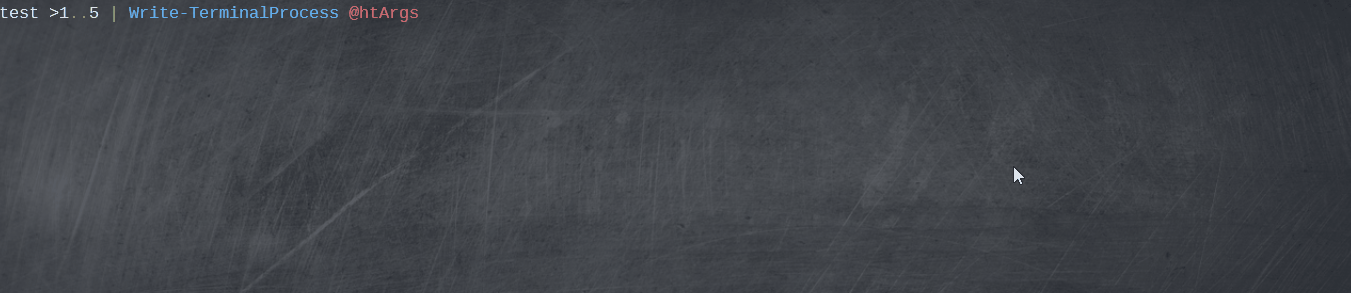